In [1]:
import matplotlib.pyplot as plt
import numpy as np


frames = np.load('frames.npy', allow_pickle=True)
labels = np.load('labels.npy', allow_pickle=True)


In [2]:
print(len(frames))

14


In [3]:
x_arr = []
for i in range(len(frames)):
    poses = frames[i]
    for pose in poses:
        value = pose[0]['pose']['keypoints'][0]['position']['y']
        print(value)
        x_arr.append(value)


235.47193739149304
235.50617775721855
235.50617775721855
239.18556020041422
239.18556020041422
233.4635488052814
230.11815359253166
230.11815359253166
230.55894342314662
230.55894342314662
231.0801800882142
231.0801800882142
232.96858343232213
232.96858343232213
231.8724366424144
231.8724366424144
229.90170246444018
231.46120127181558
231.46120127181558
229.54081990797846
231.16190295005634
231.42139457122624
232.24389624642117
232.8981253045809
232.8981253045809
227.1971716332389
227.1971716332389
230.39637574907863
229.33413262023328
229.69394438448006
230.64152291876064
230.64152291876064
229.08093309309515
231.16992139909235
229.3487263283534
229.6801805403265
229.4560845507051
229.4560845507051
229.97875905176352
23.94426699037905
23.22078682525813
23.22078682525813
23.624643247727064
24.64243303265488
24.64243303265488
27.021631906371823
29.735078867415936
33.16392508166575
33.16392508166575
42.85101550364354
42.85101550364354
51.44758555391843
51.44758555391843
59.78326615301952

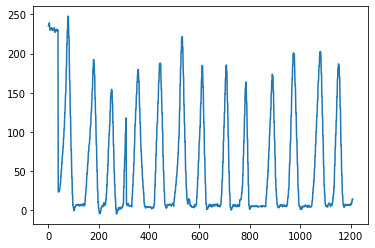

In [4]:
plt.plot(x_arr)